Copyright (c) 2021, salesforce.com, inc.  
All rights reserved.  
SPDX-License-Identifier: BSD-3-Clause  
For full license text, see the LICENSE file in the repo root or https://opensource.org/licenses/BSD-3-Clause

# This notebook will be used to gather real-world data and perform data processing in order to use it in the covid-19 simulation.

### All the downloaded data will be formatted into pandas dataframes.

## Below is the list of COVID-19 data sources used in this notebook

1. **US state government policies** (Oxford Covid-19 Government Response Tracker (OxCGRT))

    https://github.com/OxCGRT/USA-covid-policy


2. **US federal government direct payments** (Committee for a Responsible Federal Budget)

    https://www.covidmoneytracker.org/
    
    https://docs.google.com/spreadsheets/d/1Nr_J5wLfUT4IzqSXkYbdOXrRgEkBxhX0/edit#gid=682404301
    

3. **US deaths data** (COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University)

    https://github.com/CSSEGISandData/COVID-19


4. **US vaccinations** (Our World in Data)
    
    https://ourworldindata.org/covid-vaccinations
    
    
5. **US unemployment** (Bureau of Labor and Statistics)

    https://www.bls.gov/lau/

### Dependencies

In [1]:
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import scipy
from scipy.signal import convolve

### Classes to fetch the real-world data

In [2]:
from ai_economist.datasets.covid19_datasets.us_policies import DatasetCovidPoliciesUS
from ai_economist.datasets.covid19_datasets.us_deaths import DatasetCovidDeathsUS
from ai_economist.datasets.covid19_datasets.us_vaccinations import DatasetCovidVaccinationsUS
from ai_economist.datasets.covid19_datasets.us_unemployment import DatasetCovidUnemploymentUS

Inside covid19_components.py: 1 GPUs are available.
Inside covid19_env.py: 1 GPUs are available.


### Set a base directory where you would like to download real world data. The latest data will be downloaded into a folder within the base directory, named using the current date

In [3]:
current_directory = os.getcwd()
BASE_DATA_DIR_PATH = current_directory

In [4]:
DOWNLOAD_LATEST_DATA = True  # Download the latest data or use whatever is saved earlier 
CURRENT_DATE = datetime.now()
DATE_FORMAT = "%Y-%m-%d"
date_string = CURRENT_DATE.strftime(DATE_FORMAT).replace('/','-')
data_dir = os.path.join(BASE_DATA_DIR_PATH, date_string)

print("All the data will be downloaded to the directory: '{}'.".format(data_dir))

All the data will be downloaded to the directory: '/home/dominus/ai-economist/ai_economist/datasets/covid19_datasets/2025-05-31'.


In [5]:
# Set up dictionary to write model constants
model_constants = {}
model_constants_filename = "model_constants.json"

# Gather real-world data

# 1. COVID-19 US State Government Policies
### Source: Oxford Covid-19 Government Response Tracker (OxCGRT) 
(https://github.com/OxCGRT/USA-covid-policy)

**NOTE:** All data will use the same format as **policy_df** (below) and use the same date index

In [6]:
covid_policies_us = DatasetCovidPoliciesUS(
    data_dir=data_dir,
    download_latest_data=DOWNLOAD_LATEST_DATA
)

# Which of the policy indicators to treat as the open/close level
STRINGENCY_POLICY_KEY = 'StringencyIndex'
# Number of levels to discretize the stringency policy into. 
# In the context of reinforcement learning, this also determines the action space of the agents.
NUM_STRINGENCY_LEVELS = 10

policies_us_df = covid_policies_us.process_policy_data(
    stringency_policy_key=STRINGENCY_POLICY_KEY,
    num_stringency_levels=NUM_STRINGENCY_LEVELS
)

print("Policy data are available between {} and {}".format(policies_us_df["Date"].min(), 
                                                           policies_us_df["Date"].max()))

policy_df = policies_us_df.pivot(
    index="Date", columns="RegionName", values=STRINGENCY_POLICY_KEY
)

Fetching latest U.S. COVID-19 policies data from OxCGRT, and saving it in /home/dominus/ai-economist/ai_economist/datasets/covid19_datasets/2025-05-31
Policy data are available between 2020-01-01 00:00:00 and 2022-12-31 00:00:00


In [7]:
# This is the common date index that all the dataframes will use
COMMON_DATE_INDEX = policy_df.index

In [8]:
print(len(COMMON_DATE_INDEX))

1096


In [9]:
# This is the list of states (in order) all the dataframes will use
US_STATE_ORDER = policy_df.columns.values

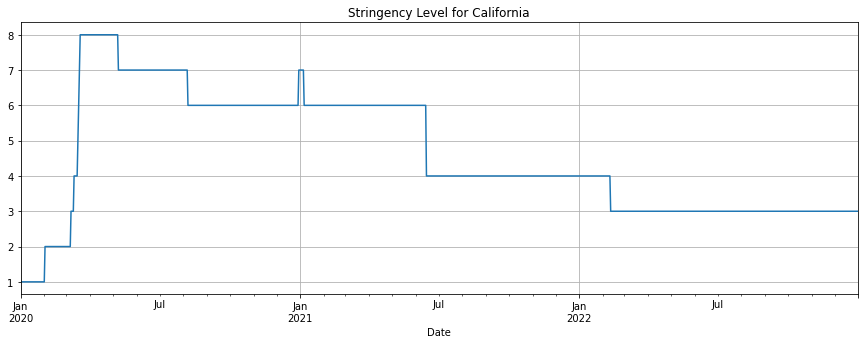

In [10]:
# Visualize the stringency level for a specified US state
state = "California"
policy_df[state].plot(figsize=(15,5), x='Date', title="Stringency Level for {}".format(state), grid=True);

# 2. COVID-19 Federal government subsidies (direct payments) to the states
### Source: Committee For A Responsible Federal Budget
https://www.covidmoneytracker.org/

### Direct payments provided by the Federal Government so far are recorded in this google spreadsheet
https://docs.google.com/spreadsheets/d/1Nr_J5wLfUT4IzqSXkYbdOXrRgEkBxhX0/edit#gid=682404301
### Read as (date: direct payment amount)
2020-04-15: 274B

2020-12-27: 142B

2021-03-11: 386B

In [11]:
subsidy_df = pd.DataFrame(policy_df.index).set_index("Date")
subsidy_df["USA"] = 0.0

# This is just direct payment
subsidy_df.loc["2020-04-15", "USA"] = 274e9
subsidy_df.loc["2020-12-27", "USA"] = 142e9
subsidy_df.loc["2021-03-11", "USA"] = 386e9

In [12]:

# These are all payment programs
# subsidy_df.loc["2020-03-27", "USA"] = 2594.319012 * 10 ** 9
# subsidy_df.loc["2020-04-09", "USA"] = 476.961463 * 10 ** 9
# subsidy_df.loc["2020-04-15", "USA"] = 273.921557 * 10 ** 9
# subsidy_df.loc["2020-07-13", "USA"] = 0.009 * 10 ** 9
# subsidy_df.loc["2020-07-23", "USA"] = 48.941446 * 10 ** 9
# subsidy_df.loc["2020-08-14", "USA"] = 20.000 * 10 ** 9
# subsidy_df.loc["2020-09-13", "USA"] = 202.300 * 10 ** 9
# subsidy_df.loc["2020-12-27", "USA"] = 375.592905 * 10 ** 9
# subsidy_df.loc["2021-03-11", "USA"] = 654.271913 * 10 ** 9


In [13]:
inflation_df = pd.DataFrame(policy_df.index).set_index("Date")
inflation_df["USA"] = 0.0


# 2020 Data
inflation_df.loc["2020-03-22", "USA"] = 1.5
inflation_df.loc["2020-04-01", "USA"] = 0.3
inflation_df.loc["2020-05-01", "USA"] = 0.1
inflation_df.loc["2020-06-01", "USA"] = 0.6
inflation_df.loc["2020-07-01", "USA"] = 1.0
inflation_df.loc["2020-08-01", "USA"] = 1.3
inflation_df.loc["2020-09-01", "USA"] = 1.4
inflation_df.loc["2020-10-01", "USA"] = 1.2
inflation_df.loc["2020-11-01", "USA"] = 1.2
inflation_df.loc["2020-12-01", "USA"] = 1.4

# 2021 Data
inflation_df.loc["2021-01-01", "USA"] = 1.4
inflation_df.loc["2021-02-01", "USA"] = 1.7
inflation_df.loc["2021-03-01", "USA"] = 2.6
inflation_df.loc["2021-04-01", "USA"] = 4.2
inflation_df.loc["2021-05-01", "USA"] = 5.0
inflation_df.loc["2021-06-01", "USA"] = 5.4
inflation_df.loc["2021-07-01", "USA"] = 5.4
inflation_df.loc["2021-08-01", "USA"] = 5.3
inflation_df.loc["2021-09-01", "USA"] = 5.4
inflation_df.loc["2021-10-01", "USA"] = 6.2
inflation_df.loc["2021-11-01", "USA"] = 6.8
inflation_df.loc["2021-12-01", "USA"] = 7.0

# 2022 Data
inflation_df.loc["2022-01-01", "USA"] = 7.5
inflation_df.loc["2022-02-01", "USA"] = 7.9
inflation_df.loc["2022-03-01", "USA"] = 8.5
inflation_df.loc["2022-04-01", "USA"] = 8.3
inflation_df.loc["2022-05-01", "USA"] = 8.6
inflation_df.loc["2022-06-01", "USA"] = 9.1
inflation_df.loc["2022-07-01", "USA"] = 8.5
inflation_df.loc["2022-08-01", "USA"] = 8.3
inflation_df.loc["2022-09-01", "USA"] = 8.2
inflation_df.loc["2022-10-01", "USA"] = 7.7
inflation_df.loc["2022-11-01", "USA"] = 7.1
inflation_df.loc["2022-12-01", "USA"] = 6.5

In [14]:
# https://www.federalreserve.gov/monetarypolicy/bst_recenttrends_accessible.htm
quantitative_df = pd.DataFrame(policy_df.index).set_index("Date")
quantitative_df["USA"] = 0.0

quantitative_df.loc["2020-03-22", "USA"] = 5254278
quantitative_df.loc["2020-04-01", "USA"] = 5811607
quantitative_df.loc["2020-04-08", "USA"] = 6083141
quantitative_df.loc["2020-04-15", "USA"] = 6367887
quantitative_df.loc["2020-04-22", "USA"] = 6573136
quantitative_df.loc["2020-04-29", "USA"] = 6655929
quantitative_df.loc["2020-05-06", "USA"] = 6721420
quantitative_df.loc["2020-05-13", "USA"] = 6934227
quantitative_df.loc["2020-05-20", "USA"] = 7037258
quantitative_df.loc["2020-05-27", "USA"] = 7097316
quantitative_df.loc["2020-06-03", "USA"] = 7165217
quantitative_df.loc["2020-06-10", "USA"] = 7168936
quantitative_df.loc["2020-06-17", "USA"] = 7094690
quantitative_df.loc["2020-06-24", "USA"] = 7082302
quantitative_df.loc["2020-07-01", "USA"] = 7009040
quantitative_df.loc["2020-07-08", "USA"] = 6920716
quantitative_df.loc["2020-07-15", "USA"] = 6958604
quantitative_df.loc["2020-07-22", "USA"] = 6964755
quantitative_df.loc["2020-07-29", "USA"] = 6949032
quantitative_df.loc["2020-08-05", "USA"] = 6945237
quantitative_df.loc["2020-08-12", "USA"] = 6957277
quantitative_df.loc["2020-08-19", "USA"] = 7010637
quantitative_df.loc["2020-08-26", "USA"] = 6990418
quantitative_df.loc["2020-09-02", "USA"] = 7017492
quantitative_df.loc["2020-09-09", "USA"] = 7010614
quantitative_df.loc["2020-09-16", "USA"] = 7064475
quantitative_df.loc["2020-09-23", "USA"] = 7093161
quantitative_df.loc["2020-09-30", "USA"] = 7056129
quantitative_df.loc["2020-10-07", "USA"] = 7074649
quantitative_df.loc["2020-10-14", "USA"] = 7151426
quantitative_df.loc["2020-10-21", "USA"] = 7177265
quantitative_df.loc["2020-10-28", "USA"] = 7146306
quantitative_df.loc["2020-11-04", "USA"] = 7157479
quantitative_df.loc["2020-11-11", "USA"] = 7175417
quantitative_df.loc["2020-11-18", "USA"] = 7243080
quantitative_df.loc["2020-11-25", "USA"] = 7216480
quantitative_df.loc["2020-12-02", "USA"] = 7222414
quantitative_df.loc["2020-12-09", "USA"] = 7242658
quantitative_df.loc["2020-12-16", "USA"] = 7362592
quantitative_df.loc["2020-12-23", "USA"] = 7404039
quantitative_df.loc["2020-12-30", "USA"] = 7363351
quantitative_df.loc["2021-01-06", "USA"] = 7334809
quantitative_df.loc["2021-01-13", "USA"] = 7333968
quantitative_df.loc["2021-01-20", "USA"] = 7414942
quantitative_df.loc["2021-01-27", "USA"] = 7404926
quantitative_df.loc["2021-02-03", "USA"] = 7410598
quantitative_df.loc["2021-02-10", "USA"] = 7442225
quantitative_df.loc["2021-02-17", "USA"] = 7557402
quantitative_df.loc["2021-02-24", "USA"] = 7590111
quantitative_df.loc["2021-03-03", "USA"] = 7557524
quantitative_df.loc["2021-03-10", "USA"] = 7579901
quantitative_df.loc["2021-03-17", "USA"] = 7693506
quantitative_df.loc["2021-03-24", "USA"] = 7719622
quantitative_df.loc["2021-03-31", "USA"] = 7688988
quantitative_df.loc["2021-04-07", "USA"] = 7708882
quantitative_df.loc["2021-04-14", "USA"] = 7793104
quantitative_df.loc["2021-04-21", "USA"] = 7820948
quantitative_df.loc["2021-04-28", "USA"] = 7780962
quantitative_df.loc["2021-05-05", "USA"] = 7810486
quantitative_df.loc["2021-05-12", "USA"] = 7830663
quantitative_df.loc["2021-05-19", "USA"] = 7922883
quantitative_df.loc["2021-05-26", "USA"] = 7903541
quantitative_df.loc["2021-06-02", "USA"] = 7935703
quantitative_df.loc["2021-06-09", "USA"] = 7952327
quantitative_df.loc["2021-06-16", "USA"] = 8064257
quantitative_df.loc["2021-06-23", "USA"] = 8101945
quantitative_df.loc["2021-06-30", "USA"] = 8078544
quantitative_df.loc["2021-07-07", "USA"] = 8097773
quantitative_df.loc["2021-07-14", "USA"] = 8201651
quantitative_df.loc["2021-07-21", "USA"] = 8240530
quantitative_df.loc["2021-07-28", "USA"] = 8221473
quantitative_df.loc["2021-08-04", "USA"] = 8235073
quantitative_df.loc["2021-08-11", "USA"] = 8257159
quantitative_df.loc["2021-08-18", "USA"] = 8342598
quantitative_df.loc["2021-08-25", "USA"] = 8332743
quantitative_df.loc["2021-09-01", "USA"] = 8349173
quantitative_df.loc["2021-09-08", "USA"] = 8357314
quantitative_df.loc["2021-09-15", "USA"] = 8448770
quantitative_df.loc["2021-09-22", "USA"] = 8489824
quantitative_df.loc["2021-09-29", "USA"] = 8447981
quantitative_df.loc["2021-10-06", "USA"] = 8464032
quantitative_df.loc["2021-10-13", "USA"] = 8480942
quantitative_df.loc["2021-10-20", "USA"] = 8564943
quantitative_df.loc["2021-10-27", "USA"] = 8556181
quantitative_df.loc["2021-11-03", "USA"] = 8574871
quantitative_df.loc["2021-11-10", "USA"] = 8663117
quantitative_df.loc["2021-11-17", "USA"] = 8674970
quantitative_df.loc["2021-11-24", "USA"] = 8681771
quantitative_df.loc["2021-12-01", "USA"] = 8650402
quantitative_df.loc["2021-12-08", "USA"] = 8664524
quantitative_df.loc["2021-12-15", "USA"] = 8756666
quantitative_df.loc["2021-12-22", "USA"] = 8790495
quantitative_df.loc["2021-12-29", "USA"] = 8757460
quantitative_df.loc["2022-01-05", "USA"] = 8765721
quantitative_df.loc["2022-01-12", "USA"] = 8788278
quantitative_df.loc["2022-01-19", "USA"] = 8867834
quantitative_df.loc["2022-01-26", "USA"] = 8860485
quantitative_df.loc["2022-01-26", "USA"] = 8860485
quantitative_df.loc["2022-02-02", "USA"] = 8873211
quantitative_df.loc["2022-02-09", "USA"] = 8878009
quantitative_df.loc["2022-02-16", "USA"] = 8911033
quantitative_df.loc["2022-02-23", "USA"] = 8928129
quantitative_df.loc["2022-03-02", "USA"] = 8904455
quantitative_df.loc["2022-03-09", "USA"] = 8910748
quantitative_df.loc["2022-03-16", "USA"] = 8954306
quantitative_df.loc["2022-03-22", "USA"] = 8962474
quantitative_df.loc["2022-03-30", "USA"] = 8937142
quantitative_df.loc["2022-04-06", "USA"] = 8937592
quantitative_df.loc["2022-04-13", "USA"] = 8965487
quantitative_df.loc["2022-04-20", "USA"] = 8955851
quantitative_df.loc["2022-04-27", "USA"] = 8939199
quantitative_df.loc["2022-05-04", "USA"] = 8939972
quantitative_df.loc["2022-05-11", "USA"] = 8942008
quantitative_df.loc["2022-05-18", "USA"] = 8945898
quantitative_df.loc["2022-05-25", "USA"] = 8914281
quantitative_df.loc["2022-06-01", "USA"] = 8915050
quantitative_df.loc["2022-06-08", "USA"] = 8918254
quantitative_df.loc["2022-06-15", "USA"] = 8932420
quantitative_df.loc["2022-06-22", "USA"] = 8934346
quantitative_df.loc["2022-06-29", "USA"] = 8913553
quantitative_df.loc["2022-07-06", "USA"] = 8891851
quantitative_df.loc["2022-07-13", "USA"] = 8895867
quantitative_df.loc["2022-07-20", "USA"] = 8899213
quantitative_df.loc["2022-07-27", "USA"] = 8890004
quantitative_df.loc["2022-08-03", "USA"] = 8874620
quantitative_df.loc["2022-08-10", "USA"] = 8879138
quantitative_df.loc["2022-08-17", "USA"] = 8849762
quantitative_df.loc["2022-08-24", "USA"] = 8851436
quantitative_df.loc["2022-08-31", "USA"] = 8826093
quantitative_df.loc["2022-09-07", "USA"] = 8822401
quantitative_df.loc["2022-09-14", "USA"] = 8832759
quantitative_df.loc["2022-09-21", "USA"] = 8816802
quantitative_df.loc["2022-09-28", "USA"] = 8795567
quantitative_df.loc["2022-10-05", "USA"] = 8759053
quantitative_df.loc["2022-10-12", "USA"] = 8758969
quantitative_df.loc["2022-10-19", "USA"] = 8743922
quantitative_df.loc["2022-10-26", "USA"] = 8723090
quantitative_df.loc["2022-11-02", "USA"] = 8676870
quantitative_df.loc["2022-11-09", "USA"] = 8678886
quantitative_df.loc["2022-11-16", "USA"] = 8625620
quantitative_df.loc["2022-11-23", "USA"] = 8621390
quantitative_df.loc["2022-11-30", "USA"] = 8584576
quantitative_df.loc["2022-12-07", "USA"] = 8582735
quantitative_df.loc["2022-12-14", "USA"] = 8583413
quantitative_df.loc["2022-12-21", "USA"] = 8564411

# Forgot to put quantitative_df *= 10**6 , so I will put this to my code

In [ ]:
# https://fiscaldata.treasury.gov/datasets/monthly-statement-public-debt/summary-of-treasury-securities-outstanding
debt_df = pd.DataFrame(policy_df.index).set_index("Date")
debt_df["USA"] = 0.0
debt_df.loc["2022-12-31", "USA"] = 31419689.42
debt_df.loc["2022-11-30", "USA"] = 31413322.43
debt_df.loc["2022-10-31", "USA"] = 31238301.16
debt_df.loc["2022-09-30", "USA"] = 30928911.59
debt_df.loc["2022-08-31", "USA"] = 30936075.19
debt_df.loc["2022-07-31", "USA"] = 30595108.62
debt_df.loc["2022-06-30", "USA"] = 30568581.74
debt_df.loc["2022-05-31", "USA"] = 30499619.22
debt_df.loc["2022-04-30", "USA"] = 30374155.17
debt_df.loc["2022-03-31", "USA"] = 30400959.63
debt_df.loc["2022-02-28", "USA"] = 30290353.33
debt_df.loc["2022-01-31", "USA"] = 30012385.73
debt_df.loc["2021-12-31", "USA"] = 29617214.52
debt_df.loc["2021-11-30", "USA"] = 28907987.47
debt_df.loc["2021-10-31", "USA"] = 28908764.86
debt_df.loc["2021-09-30", "USA"] = 28428919.11
debt_df.loc["2021-08-31", "USA"] = 28427316.75
debt_df.loc["2021-07-31", "USA"] = 28427721.59
debt_df.loc["2021-06-30", "USA"] = 28529436.13
debt_df.loc["2021-05-31", "USA"] = 28199007.68
debt_df.loc["2021-04-30", "USA"] = 28174714.3
debt_df.loc["2021-03-31", "USA"] = 28132570.05
debt_df.loc["2021-02-28", "USA"] = 27902364.08
debt_df.loc["2021-01-31", "USA"] = 27784552.55
debt_df.loc["2020-12-31", "USA"] = 27747797.52
debt_df.loc["2020-11-30", "USA"] = 27446288.23
debt_df.loc["2020-10-31", "USA"] = 27135476.66
debt_df.loc["2020-09-30", "USA"] = 26945391.18
debt_df.loc["2020-08-31", "USA"] = 26728835.85
debt_df.loc["2020-07-31", "USA"] = 26524952.91
debt_df.loc["2020-06-30", "USA"] = 26477240.63
debt_df.loc["2020-05-31", "USA"] = 25746260.37
debt_df.loc["2020-04-30", "USA"] = 24974171.87
debt_df.loc["2020-03-22", "USA"] = 23686871
debt_df *= 10**6 
# debt_df = debt_df.sort_values(by='Date')
print(debt_df)

                     USA
Date                    
2020-01-01  0.000000e+00
2020-01-02  0.000000e+00
2020-01-03  0.000000e+00
2020-01-04  0.000000e+00
2020-01-05  0.000000e+00
...                  ...
2022-12-27  0.000000e+00
2022-12-28  0.000000e+00
2022-12-29  0.000000e+00
2022-12-30  0.000000e+00
2022-12-31  3.141969e+13

[1096 rows x 1 columns]


In [16]:
# https://fred.stlouisfed.org/series/DFEDTARU
fed_fund_rate_df = pd.DataFrame(policy_df.index).set_index("Date")
fed_fund_rate_df["USA"] = 0.0  
fed_fund_rate_df.loc["2020-03-22", "USA"] = 0.25
fed_fund_rate_df.loc["2022-03-17", "USA"] = 0.5
fed_fund_rate_df.loc["2022-05-05", "USA"] = 1.0
fed_fund_rate_df.loc["2022-06-16", "USA"] = 1.75
fed_fund_rate_df.loc["2022-07-28", "USA"] = 2.5
fed_fund_rate_df.loc["2022-09-22", "USA"] = 3.25
fed_fund_rate_df.loc["2022-11-03", "USA"] = 4.0
fed_fund_rate_df.loc["2022-12-15", "USA"] = 4.5
fed_fund_rate_df.loc["2023-02-02", "USA"] = 4.75
fed_fund_rate_df.loc["2023-03-22", "USA"] = 5.0
fed_fund_rate_df.loc["2023-05-04", "USA"] = 5.25
fed_fund_rate_df.loc["2023-07-27", "USA"] = 5.5


In [17]:

us_treasury_yield_long_10_years = pd.DataFrame(policy_df.index).set_index("Date")
us_treasury_yield_long_10_years["USA"] = 0.0
us_treasury_yield_long_10_years.loc["2020-03-22", "USA"] = 1.92
us_treasury_yield_long_10_years.loc["2021-01-05", "USA"] = 0.96
us_treasury_yield_long_10_years.loc["2022-01-03", "USA"] = 1.63


In [18]:
# CBO 2019 - 2020 - 2021 Fiscal Year
us_revenue_df = pd.DataFrame(policy_df.index).set_index("Date")
us_revenue_df["USA"] = 0.0
us_revenue_df.loc["2020-03-22", "USA"] = 3.4 * 10**12
us_revenue_df.loc["2020-12-31", "USA"] = 3.4 * 10**12
us_revenue_df.loc["2021-12-31", "USA"] = 4 * 10**12

us_spending_df = pd.DataFrame(policy_df.index).set_index("Date")
us_spending_df["USA"] = 0.0
us_spending_df.loc["2020-03-22", "USA"] = 4.47 * 10**12
us_spending_df.loc["2020-12-31", "USA"] = 6.55 * 10**12
us_spending_df.loc["2021-12-31", "USA"] = 6.8 * 10**12

# 3. COVID-19 Deaths data
### Source: COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University 
(https://github.com/CSSEGISandData/COVID-19)

In [19]:
deaths_us_df = DatasetCovidDeathsUS(
    data_dir=data_dir,
    download_latest_data=DOWNLOAD_LATEST_DATA
).df

print("COVID-19 death data for the US is available between {} and {}".format(
    deaths_us_df.columns[12], deaths_us_df.columns[-1]))

Fetching latest U.S. COVID-19 deaths data from John Hopkins, and saving it in /home/dominus/ai-economist/ai_economist/datasets/covid19_datasets/2025-05-31
COVID-19 death data for the US is available between 1/22/20 and 3/9/23


In [20]:
# Retain just the states in US_STATE_ORDER
deaths_us_df = deaths_us_df[deaths_us_df.Province_State.isin(US_STATE_ORDER)]

# We will visualize this later in the notebook

# 4. COVID-19 Vaccination Data
### Source: Our World in Data
(https://ourworldindata.org/covid-vaccinations)

In [21]:
vaccinations_us_df = DatasetCovidVaccinationsUS(
    data_dir=data_dir,
    download_latest_data=DOWNLOAD_LATEST_DATA
).df

vaccination_dates = sorted(vaccinations_us_df.date.unique())
print("Vaccination data is available between {} and {}".format(min(vaccination_dates), max(vaccination_dates)))

Fetching latest U.S. COVID-19 vaccination data from Our World in Data, and saving it in /home/dominus/ai-economist/ai_economist/datasets/covid19_datasets/2025-05-31
Vaccination data is available between 2020-12-20 and 2023-05-10


In [22]:
vaccinated_df = vaccinations_us_df.pivot(
    index="date", columns="location", values="people_fully_vaccinated"
)[US_STATE_ORDER]

vaccinated_df.index = pd.to_datetime(vaccinated_df.index)
vaccinated_df = vaccinated_df.reindex(COMMON_DATE_INDEX).fillna(0)

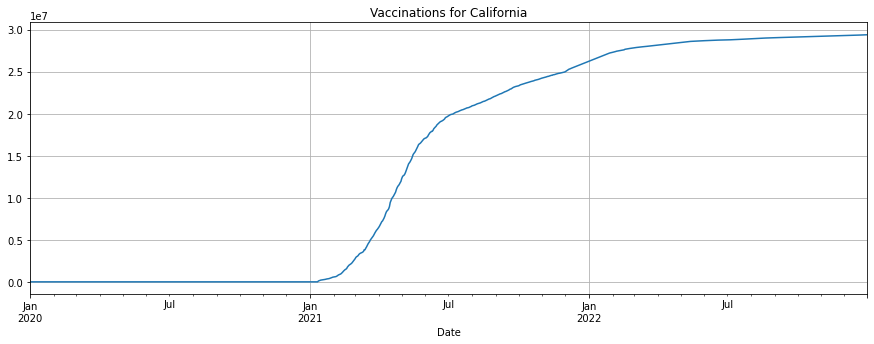

In [23]:
# Visualize the vaccinations for a specified US state
# Warning: the last value may not be updated (may show it to be 0)

state = "California"
vaccinated_df[state].plot(figsize=(15,5), x='Date', title="Vaccinations for {}".format(state), grid=True);

## Using deaths and vaccinations to compute the susceptible-infected-recovered (SIR) numbers

Our SIR data will only treat **deaths** as ground-truth.

Given death data and some assumed constants about the _death rate_ and _recovery rate_ , we can apply some "SIR algebra" (i.e. solve for unknowns using the SIR equations) to _infer_ quantities like total "recovered", number of infected people, and ultimately **Beta**, which is the rate of transmission times the number of people an infected person comes into contact with.

In [24]:
# For data representation, we will want to build a dataframe for...
# ... deaths...
deaths_df = pd.DataFrame(COMMON_DATE_INDEX, columns=['Date']).set_index('Date')
smoothed_deaths_df = pd.DataFrame(COMMON_DATE_INDEX, columns=['Date']).set_index('Date')
# ... (inferred) SIR states...
susceptible_df = pd.DataFrame(COMMON_DATE_INDEX, columns=['Date']).set_index('Date')
infected_df    = pd.DataFrame(COMMON_DATE_INDEX, columns=['Date']).set_index('Date')
recovered_df   = pd.DataFrame(COMMON_DATE_INDEX, columns=['Date']).set_index('Date')
# ... and (inferred) Beta.
beta_df = pd.DataFrame(COMMON_DATE_INDEX, columns=['Date']).set_index('Date')

In [25]:
# STD of the Gaussian smoothing window applied to the death data.
SIR_SMOOTHING_STD = 10

In [26]:
# Fill the death dataframe from (smoothed) raw data

def smooth(x, gauss_std=10):
    """
    gauss_std: standard deviation of the Gaussian smoothing window applied to the death data.
    """
    if gauss_std <= 0:
        return x
    # To invalidate the near-edge results, bookend the input x with nans
    x = np.concatenate([[np.nan], np.array(x), [np.nan]])
    
    kernel = scipy.stats.norm.pdf(
        np.linspace(-3*gauss_std, 3*gauss_std, 1+6*gauss_std),
        scale=gauss_std
    )
    normer = np.ones_like(x)
    smoothed_x = convolve(x, kernel, mode='same') / convolve(normer, kernel, mode='same')
    
    # Remove the indices added by the nan padding
    return smoothed_x[1:-1]

for us_state_name in US_STATE_ORDER:
    state_deaths = deaths_us_df[deaths_us_df['Province_State']==us_state_name]
    cumulative_state_deaths = []
    for d in COMMON_DATE_INDEX:
        date_string = '{d.month}/{d.day}/{y}'.format(d=d, y=d.year % 2000)
        if date_string in state_deaths:
            cumulative_state_deaths.append(
                state_deaths[date_string].sum()
            )
        else:
            cumulative_state_deaths.append(
                np.nan
            )
            
    # Store raw numbers (for direct comparison)
    deaths_df[us_state_name] = cumulative_state_deaths
    
    # Store smoothed numbers (for beta analysis)
    smoothed_cumulative_state_deaths = smooth(cumulative_state_deaths, gauss_std=SIR_SMOOTHING_STD)
    smoothed_deaths_df[us_state_name] = smoothed_cumulative_state_deaths

In [27]:
state_deaths = deaths_us_df[deaths_us_df['Province_State']=="California"]
cumulative_state_deaths = []
for d in COMMON_DATE_INDEX:
    date_string = '{d.month}/{d.day}/{y}'.format(d=d, y=d.year % 2000)
    if date_string in state_deaths:
        cumulative_state_deaths.append(
            state_deaths[date_string].sum()
        )
    else:
        cumulative_state_deaths.append(
            np.nan
        )

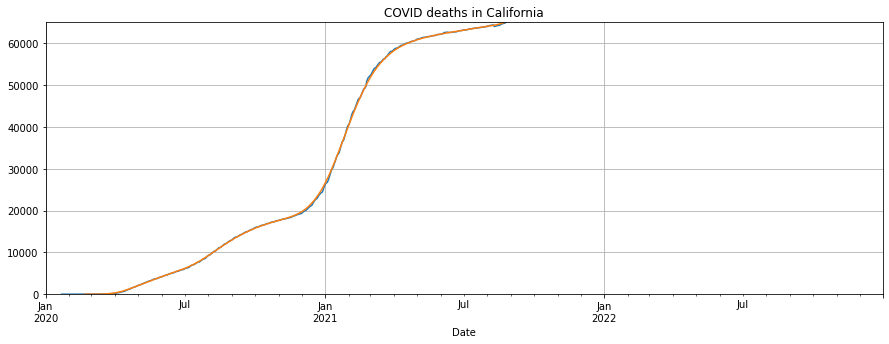

In [28]:
# Visualize the deaths for a specified US state
state = "California"

# Some values near the ends may be "missing" because of smoothing
deaths_df[state].plot(figsize=(15,5), x='Date', ylim=[0, 65000]);
smoothed_deaths_df[state].plot(figsize=(15,5), x='Date', title="COVID deaths in {}".format(state), ylim=[0, 65000], grid=True);

In [29]:
# Death rate: fraction of infected persons who die
SIR_MORTALITY = 0.02

# Recovery rate: the inverse of expected time someone remains infected
SIR_GAMMA = 1 / 14

In [30]:
# This is the core "SIR algebra" used to infer S, I, R, and Beta at each date.

def infer_sir_and_beta(us_state_name):
    state_population = deaths_us_df[deaths_us_df['Province_State']==us_state_name]['Population'].sum()
    
    # Helpful to do this math in normalized numbers
    dead = np.array(smoothed_deaths_df[us_state_name]) / state_population
    vaccinated = np.array(vaccinated_df[us_state_name]) / state_population
    
    # Dead is the fraction of "recovered" that did not survive
    # Also, the vaccinated lot is part of the recovered
    recovered = dead / SIR_MORTALITY + vaccinated
    
    # The daily change in recovered (ignoring the vaccinated) is a fraction of the infected population on the previous day
    infected = np.nan * np.zeros_like(dead)
    infected[:-1] = (recovered[1:] - recovered[:-1] - (vaccinated[1:] - vaccinated[:-1])) / SIR_GAMMA
    
    # S+I+R must always = 1
    susceptible = 1 - infected - recovered
    
    # Here's where things get interesting. The change in infected is due to...
    change_in_i = infected[1:] - infected[:-1]
    # ... infected people that transition to the recovered state (decreases I)...
    expected_change_from_recovery = -infected[:-1] * SIR_GAMMA
    # ... and susceptible people that transition to the infected state (increases I).
    new_infections = change_in_i - expected_change_from_recovery
    
    # With these pieces, we can solve for Beta.
    beta_ = new_infections / (infected[:-1] * susceptible[:-1] + 1e-6)
    beta_ = np.clip(beta_, 0, 1)
    # Apply a threshold in terms of normalized daily deaths (if too low, beta estimates are bad)
    normalized_daily_deaths = dead[1:]-dead[:-1]
    ndd_lookback = np.zeros_like(new_infections)
    lookback_window = 3*SIR_SMOOTHING_STD
    ndd_cutoff = 1e-8
    ndd_lookback[lookback_window:] = normalized_daily_deaths[:-lookback_window]
    beta_[np.logical_not(ndd_lookback > 1e-8)] = np.nan
    
    beta = np.nan * np.zeros_like(dead)
    beta[:-1] = beta_
    
    # Undo normalization
    susceptible *= state_population
    infected    *= state_population
    recovered   *= state_population
    
    return susceptible, infected, recovered, beta

In [31]:
# Fill the SIR and Beta dataframes with their inferred values
for st in US_STATE_ORDER:
    susceptible_df[st], infected_df[st], recovered_df[st], beta_df[st] = infer_sir_and_beta(us_state_name=st)

In [32]:
## Visualize the SIR and BETA for a specified US state
# Warning: some values near the ends may be "missing" because of smoothing

state = "California"

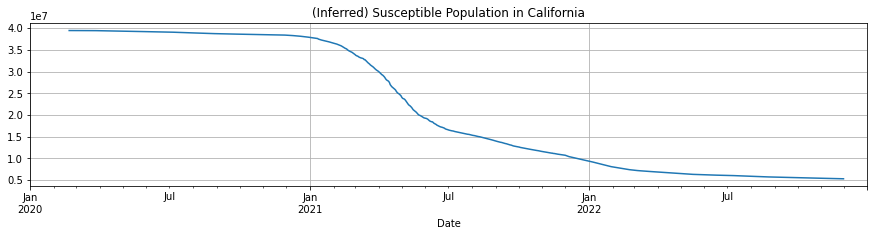

In [33]:
susceptible_df[state].plot(figsize=(15,3), x='Date', title="(Inferred) Susceptible Population in {}".format(state), grid=True);

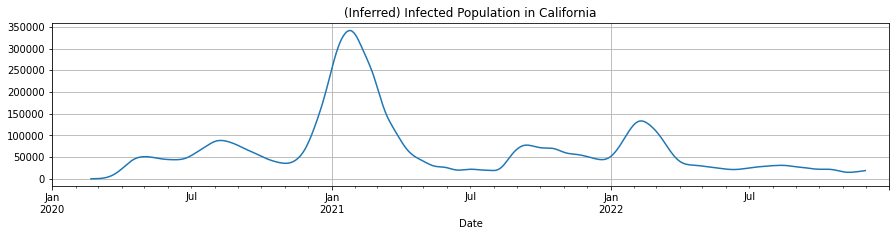

In [34]:
infected_df[state].plot(figsize=(15,3), x='Date', title="(Inferred) Infected Population in {}".format(state), grid=True);

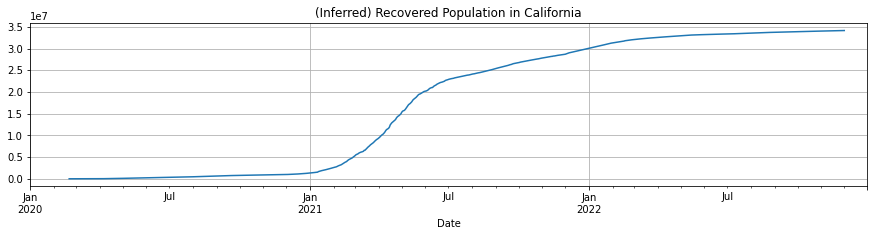

In [35]:
recovered_df[state].plot(figsize=(15,3), x='Date', title="(Inferred) Recovered Population in {}".format(state), grid=True);

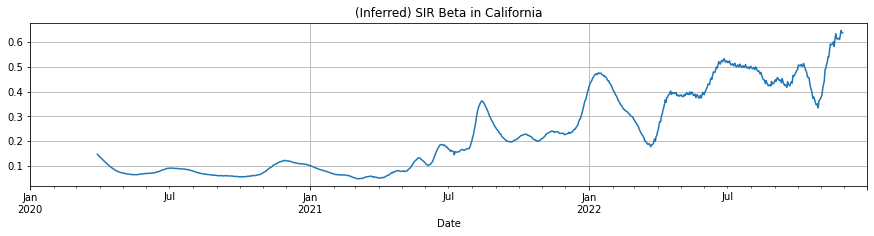

In [36]:
beta_df[state].plot(figsize=(15,3), x='Date', title="(Inferred) SIR Beta in {}".format(state), grid=True);

# 5. COVID-19 Unemployment data
### Source: Bureau of Labor and Statistics

https://www.bls.gov/lau/

In [37]:
monthly_unemployment_us = DatasetCovidUnemploymentUS(
    data_dir=data_dir,
    download_latest_data=DOWNLOAD_LATEST_DATA).data

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1091)>

In [38]:
sample_monthly_unemployment = monthly_unemployment_us['California']
unemp_year_keys = sorted(sample_monthly_unemployment.keys())
unemp_starting_month_key = sorted(sample_monthly_unemployment[unemp_year_keys[0]].keys())[0]
unemp_ending_month_key = sorted(sample_monthly_unemployment[unemp_year_keys[-1]].keys())[-1]
print(unemp_year_keys[0])
print(unemp_ending_month_key)
unemp_starting_date = datetime.strptime(
    str(unemp_year_keys[0]) + '-' + str(unemp_ending_month_key) + '-1', DATE_FORMAT)
unemp_ending_date = datetime.strptime(
    str(unemp_year_keys[-1]) + '-' + str(unemp_ending_month_key) + '-1', DATE_FORMAT) - timedelta(1)

print("Unemployment data is available between {} and {}".format(datetime.strftime(unemp_starting_date, DATE_FORMAT),
                                                                datetime.strftime(unemp_ending_date, DATE_FORMAT)))

2014
7
Unemployment data is available between 2014-07-01 and 2024-06-30


In [39]:
# Convert this to a daily unemployment dataframe

unemployment_df = pd.DataFrame(COMMON_DATE_INDEX, columns=['Date']).set_index('Date')

for us_state_name in monthly_unemployment_us.keys():
    unemployment_df[us_state_name] = [
        monthly_unemployment_us[us_state_name][x.year].get(x.month, np.nan)
        for x in unemployment_df.index
    ]
unemployment_df = unemployment_df[US_STATE_ORDER]

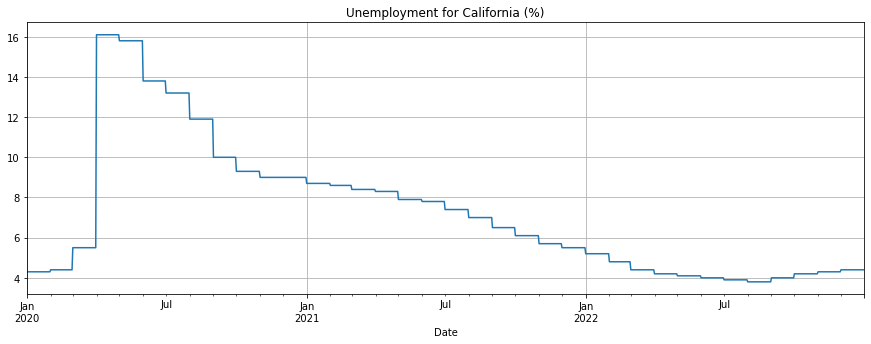

In [40]:
## Visualize the unemployment rate for a specified US state
# There is likely going to be some unemployment data missing at the tail end, 
# as the unemployment data isn't updated as frequently as the other data.

state = "California"
unemployment_df[state].plot(figsize=(15,5), x='Date', title="Unemployment for {} (%)".format(state), grid=True);

### Unemployment rate -> unemployed (the number of unemployed people)

In [41]:
us_state_to_pop_dict = {}
for us_state in US_STATE_ORDER:
    us_state_to_pop_dict[us_state] = deaths_us_df[deaths_us_df.Province_State==us_state].Population.sum()

In [42]:
unemployed_df = unemployment_df.multiply([us_state_to_pop_dict[col]/100.0 for col in unemployment_df.columns])

## Saving

### Save some of the data processing constants for use within the environment

In [43]:
model_constants_dict = {}

model_constants_dict["DATE_FORMAT"] = DATE_FORMAT
model_constants_dict["STRINGENCY_POLICY_KEY"] = STRINGENCY_POLICY_KEY
model_constants_dict["NUM_STRINGENCY_LEVELS"] = int(NUM_STRINGENCY_LEVELS)
model_constants_dict["SIR_SMOOTHING_STD"] = SIR_SMOOTHING_STD
model_constants_dict["SIR_MORTALITY"] = SIR_MORTALITY
model_constants_dict["SIR_GAMMA"] = SIR_GAMMA
model_constants_dict["US_STATE_IDX_TO_STATE_NAME"] = {
    us_state_idx: us_state for us_state_idx, us_state in enumerate(US_STATE_ORDER)
}
model_constants_dict["US_STATE_POPULATION"] = [int(us_state_to_pop_dict[us_state]) for us_state in US_STATE_ORDER]
model_constants_dict["US_POPULATION"] = int(sum([us_state_to_pop_dict[us_state] for us_state in US_STATE_ORDER]))

# 2019: https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?locations=US&view=chart
model_constants_dict["GDP_PER_CAPITA"] = 65300  # TODO: Load this in from model_constants.json.

model_constants_filename = "model_constants.json"
with open(os.path.join(data_dir, model_constants_filename), "w") as fp: 
    json.dump(model_constants_dict, fp)

### Save all the processed dataframes in order to use for model fitting notebook (fit_model_parameters.ipynb)

In [44]:
dataframes = {
    "policy": policy_df,
    "subsidy": subsidy_df,
    "quantitative": quantitative_df,
    "inflation": inflation_df,
    "fed_fund_rate": fed_fund_rate_df,
    "us_treasury_yield_long_10_years": us_treasury_yield_long_10_years,
    "revenue": us_revenue_df,
    "spending": us_spending_df,
    "debt": debt_df,
    "deaths": deaths_df,
    "vaccinated": vaccinated_df,
    "smoothed_deaths": smoothed_deaths_df,
    "susceptible": susceptible_df,
    "infected": infected_df,
    "recovered": recovered_df,
    "beta": beta_df,
    "unemployment": unemployment_df,
    "unemployed": unemployed_df,
}

for k, df in dataframes.items():
    if k == "subsidy" or k == "quantitative" or k == "fed_fund_rate" or k == "us_treasury_yield_long_10_years" \
        or k == "debt" or k == "revenue" or k == "spending" or k == "inflation":  # This is at the USA level, not at the US states level
        continue
    assert (df.columns.to_list() == US_STATE_ORDER).all()

with open(os.path.join(data_dir, 'dataframes.pkl'), 'wb') as F:
    pickle.dump(dataframes, F)

In [45]:
print(susceptible_df)

            Alabama  Alaska  Arizona  Arkansas  California  Colorado  \
Date                                                                   
2020-01-01      NaN     NaN      NaN       NaN         NaN       NaN   
2020-01-02      NaN     NaN      NaN       NaN         NaN       NaN   
2020-01-03      NaN     NaN      NaN       NaN         NaN       NaN   
2020-01-04      NaN     NaN      NaN       NaN         NaN       NaN   
2020-01-05      NaN     NaN      NaN       NaN         NaN       NaN   
...             ...     ...      ...       ...         ...       ...   
2022-12-27      NaN     NaN      NaN       NaN         NaN       NaN   
2022-12-28      NaN     NaN      NaN       NaN         NaN       NaN   
2022-12-29      NaN     NaN      NaN       NaN         NaN       NaN   
2022-12-30      NaN     NaN      NaN       NaN         NaN       NaN   
2022-12-31      NaN     NaN      NaN       NaN         NaN       NaN   

            Connecticut  Delaware  District of Columbia  Florid

In [46]:
print(quantitative_df)

            USA
Date           
2020-01-01  0.0
2020-01-02  0.0
2020-01-03  0.0
2020-01-04  0.0
2020-01-05  0.0
...         ...
2022-12-27  0.0
2022-12-28  0.0
2022-12-29  0.0
2022-12-30  0.0
2022-12-31  0.0

[1096 rows x 1 columns]


### Also save all the data as numpy arrays for use within the covid19 simulation environment

In [47]:
real_world_data = {}
for key in dataframes:
    real_world_data[key] = dataframes[key].values
    
# Save the real-world data as a .npz for use within the environment
np.savez(os.path.join(data_dir, "real_world_data.npz"), **real_world_data)    

In [48]:
real_world_data = {}
for key in dataframes:
    real_world_data[key] = dataframes[key].values
    value = dataframes[key].values
    filtered_arr = value[value != 0]
    print("Key: ", key, " - size: ", len(dataframes[key].values))
    print("Key: ", key, " - filtered_arr: ", filtered_arr)

Key:  policy  - size:  1096
Key:  policy  - filtered_arr:  [1 1 1 ... 2 2 2]
Key:  subsidy  - size:  1096
Key:  subsidy  - filtered_arr:  [2.74e+11 1.42e+11 3.86e+11]
Key:  quantitative  - size:  1096
Key:  quantitative  - filtered_arr:  [5254278. 5811607. 6083141. 6367887. 6573136. 6655929. 6721420. 6934227.
 7037258. 7097316. 7165217. 7168936. 7094690. 7082302. 7009040. 6920716.
 6958604. 6964755. 6949032. 6945237. 6957277. 7010637. 6990418. 7017492.
 7010614. 7064475. 7093161. 7056129. 7074649. 7151426. 7177265. 7146306.
 7157479. 7175417. 7243080. 7216480. 7222414. 7242658. 7362592. 7404039.
 7363351. 7334809. 7333968. 7414942. 7404926. 7410598. 7442225. 7557402.
 7590111. 7557524. 7579901. 7693506. 7719622. 7688988. 7708882. 7793104.
 7820948. 7780962. 7810486. 7830663. 7922883. 7903541. 7935703. 7952327.
 8064257. 8101945. 8078544. 8097773. 8201651. 8240530. 8221473. 8235073.
 8257159. 8342598. 8332743. 8349173. 8357314. 8448770. 8489824. 8447981.
 8464032. 8480942. 8564943. 8556

## Finally, in order to use this gathered real-world data when you run the covid19 simulation, you will need to also

### 1. Run the "fit_model_parameters.ipynb" notebook with the base data directory specified below.

In [49]:
print("BASE_DATA_DIR_PATH = '{}'".format(BASE_DATA_DIR_PATH))

BASE_DATA_DIR_PATH = '/home/ubuntu/ai-economist/ai_economist/datasets/covid19_datasets'


### 2. Set "path_to_data_and_fitted_params" in the env config also to the data directory below.

In [50]:
print("path_to_data_and_fitted_params = '{}'".format(data_dir))

path_to_data_and_fitted_params = '/home/ubuntu/ai-economist/ai_economist/datasets/covid19_datasets/2024-09-16'
